# Homedeports en MEXICO


In [1]:
import requests
from sklearn.cluster import KMeans
from shapely.geometry import Polygon, Point

# Se crea la función que genera poligonos de cobertura a partir de coordenadas
def isolineGeneration(lat:float, lng: float, cov_type: str, value: float):
    
    coordinates = 'geo!' + str(lat) + ',' + str(lng)
    api_structure = 'https://isoline.route.ls.hereapi.com/routing/7.2/calculateisoline.json'
    payload = {
    		'apiKey' : 'A6oKk5QyLYkxJ4efaUoDQZjjRNQ2bibTpYA2SE0oxiM',
    		'start' : coordinates,
            'range': value,
            'rangetype':cov_type,
            'mode': 'shortest;car;traffic:disabled'
        }
    response=requests.get(api_structure, params=payload)
    response=response.json()
    polygon = response['response']['isoline'][0]['component'][0]['shape']
    
    listPoints = []
    for i in polygon:
        coors = i.split(",")
        listPoints.append([ float(coors[1]), float(coors[0])])
    
    return listPoints

In [2]:
# Función que determina si un punto está dentro de un polígono
def inside(polygon, lat: float, lng: float):
    
    # El poligono tiene puntos de lng,lat
    testPoint = Point(lng, lat)
    
    # Si el punto está en la cobertura no pasa nada, de lo contrario se borra
    if polygon.contains(testPoint):
        return True
    else:
        return False

In [3]:
import json
import pandas as pd
# Se leen los datos de clientes y de ubicaciones de Homecenter
clients = pd.read_csv('clients.csv', index_col = 'id').fillna(0).to_dict(orient = 'index')

with open('homecenters.json', 'r', encoding="utf8") as fp:
    homecenters = json.load(fp)

In [4]:
# Se crean los poligonos de cobertura a 15mins en carro y se verifican que clientes están dentro
for i in homecenters:
    homecenters[i]['polygon'] = isolineGeneration(homecenters[i]['lat'], homecenters[i]['lng'], 'time', 400)
    homecenters[i]['clients'] = []
    for j in clients:
        if inside(Polygon(homecenters[i]['polygon']), clients[j]['lat'], clients[j]['lng']):
            homecenters[i]['clients'].append(clients[j]) 

In [5]:
# Se crea un archivo json con los poligonos para graficarlos

jsonOut = {"type": "FeatureCollection", "name": "Homecenters Bogota", "features": []}

for i in homecenters:
    jsonOut['features'].append({"type": "Feature", 
                                "properties": {"name": i},
                                "geometry": {
                                    "type": "Polygon",
                                    "coordinates": [homecenters[i]['polygon']]
                                }})

with open('HC_Polygons.json', 'w') as fp:
    json.dump(jsonOut, fp)

# Resultados

Ahora se analizan los datos obtenidos.

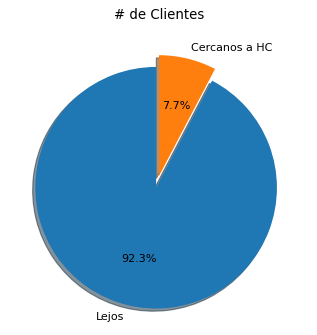

In [6]:
import matplotlib.pyplot as plt

# Número de clientes totales en el Universo y # de clientes cercanos a Homecenters
plt.figure(figsize=(14, 5), dpi=80)
labels = ['Lejos', 'Cercanos a HC']
sizes = [len(clients)-sum([len(homecenters[i]['clients']) for i in homecenters]), 
         sum([len(homecenters[i]['clients']) for i in homecenters])]
explode = (0.1, 0)

plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('# de Clientes')
plt.show()

Coapa - 0 - 0 - 0
Miramontes - 0 - 0 - 0
Los Reyes Coyacan - 0 - 0 - 0
San Jeronimo - 0 - 0 - 0
Av Central - 0 - 0 - 0
Patio Santa fe - 1 - 0 - 0.0
Mexico Centro - 17 - 7 - 39300.10697752
Mexico - 2 - 0 - 0.0
Jardin - 18 - 12 - 44605.765617271
Fortuna - 28 - 13 - 45943.086417106
Lomas verdes - 17 - 7 - 171299.486516545
Autopista Mexico - 16 - 6 - 172232.362277198
Esmeralda Atizapan - 0 - 0 - 0
Aragon Ecatepec - 19 - 10 - 331467.73211030196
Hacienda Xalpa - 7 - 6 - 198545.824090752
Coacalco - 19 - 13 - 902697.433881634
Cauutitlan Izcalli - 4 - 3 - 51666.472842752


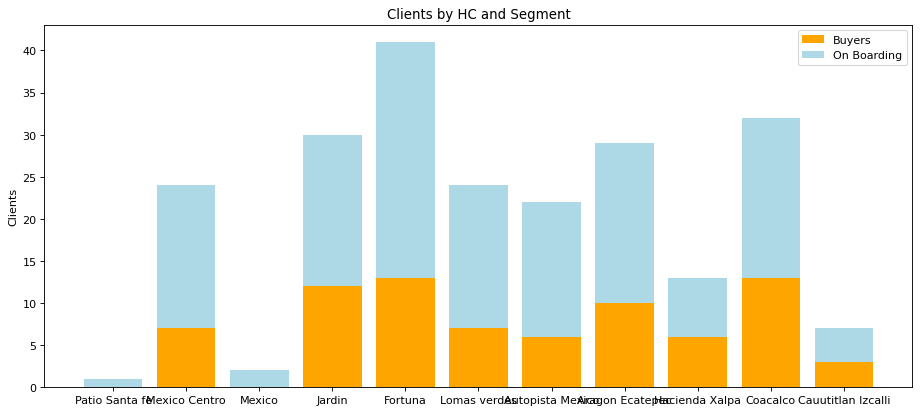

In [16]:
# Se calcula el numero de clientes para cada homecenter:
plt.figure(figsize=(14, 6), dpi=80)
y1, y2, y3, l = [],[],[],[]
for i in homecenters:
    noBuyers = 0
    Buyers = 0
    total = 0
    for j in homecenters[i]['clients']:
        total += j['acum_total']
        if j['acum_total'] == 0:
            noBuyers += 1
        else: Buyers += 1
    if (noBuyers+Buyers) >0:
        y1.append(noBuyers)
        y2.append(Buyers)
        y3.append(total)
        l.append(i)
    print(i, '-', noBuyers,'-', Buyers, '-',total)
plt.bar(l, y2, label = 'Buyers', color = 'orange')
plt.bar(l, y1, label = 'On Boarding', color = 'lightblue', bottom=y2)

plt.ylabel('Clients')
plt.title('Clients by HC and Segment')
plt.legend()

In [8]:
import pandas as pd

homC = pd.read_excel('homecentersXLS.xlsx', index_col = 'id').to_dict(orient='index')
print(homC)

{'Coapa': {'Direccion': 'Calz. del Hueso 670, Coapa, Los Robles, Coyoacán, 04870 Ciudad de México, CDMX, México', 'lat': 19.3027383, 'lng': -99.118472}, 'Miramontes': {'Direccion': 'Canal de Miramontes 2053, Coapa, Girasoles III, Coyoacán, 04920 Ciudad de México, CDMX, México', 'lat': 19.3089371, 'lng': -99.1243973}, 'Los Reyes Coyacan': {'Direccion': 'Eje 10 Sur 546, Los Reyes, Coyoacán, 04330 Coyoacan, CDMX, México', 'lat': 19.3355568, 'lng': -99.1574614}, 'San Jeronimo': {'Direccion': 'Av. San Jerónimo esq, Periferico Sur 630, La Otra Banda, 01090 Del. Álvaro Obregón, CDMX, México', 'lat': 19.3283215, 'lng': -99.2099739}, 'Av Central': {'Direccion': 'Av. Central Alta Tensión Del, Alfonso XIII, 01460 Ciudad de México, México', 'lat': 19.3779413, 'lng': -99.1999109}, 'Patio Santa fe': {'Direccion': 'Prolongacion Paseo de la Reforma 400, Santa Fe, Zedec Sta Fé, Álvaro Obregón, 01210 Ciudad de México, CDMX, México', 'lat': 19.3774649, 'lng': -99.2535788}, 'Mexico Centro': {'Direccion': 